In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import sys
from scipy.optimize import curve_fit, leastsq

%matplotlib inline

In [2]:
def create_df(filename):
    df= pd.read_json(filename)
    return df

def filter_data(df):    
    mean = df['price'].mean()
    std = df['price'].std()
    lower_range = mean - 2*std
    upper_range = mean + 2*std
    mask = (df['price'] >= lower_range) & (df['price'] <= upper_range)
    print(len(df['price']))
    df = df.loc[mask]
    print(len(df['price']))

    df['departure'] = pd.to_datetime(df['departure'].str[:10])

    df.index = df['departure']
    return df
    
def sort_by_date(df):
    df2 = pd.DataFrame(index=df.index.unique(), columns=['price'])

    for i in df.index.unique():
        df2.loc[i] = pd.Series(df.loc[i, 'price']).quantile(q=0.15)
    return df2



In [ ]:
df_names = ['BHX_to_IAS','MAN_to_IAS']
dict_df = {}
small_df = {}
for df_name in df_names:
    
    dict_df[df_name] = create_df(df_name+'.json')
    dict_df[df_name] = filter_data(dict_df[df_name])
    small_df[df_name] = sort_by_date(dict_df[df_name])



### This creates a line of best fit using a series of sine waves

In [4]:
def return_val(dict_df, df_name):
    df = dict_df[df_name]
    y = df['price']
    x = df.index
    x_line = np.array(x.astype(int) / 10**9)
    # Finding the amplitude of the sin waves
    amp = abs(np.fft.fft(y))
    #Sorting the indices of the amplitudes in descending order
    indices = np.flip(np.argsort(amp))
    # Finding the frequency of the sin waves
    freq = np.fft.fftfreq(len(x_line), (x_line[1]-x_line[0]))
    guess_amp = np.std(y) * 2**0.5
    guess_freq = abs(freq[np.argmax(amp[1:])+1])
    phase = 0
    guess_offset = np.mean(y) * 2**0.5
    guess = [guess_amp, 2*np.pi*guess_freq, phase,  guess_offset]
    return x, y, x_line, amp, freq, phase, guess_offset, indices


def sinfunc(x, a, w, p):
    return a * np.sin(x*w+p)
def est_param(x_line, y, a, w, p, c, indices):
    est_amps = np.empty(len(a))
    est_freq = np.empty(len(a))
    est_phase = np.empty(len(a))
    for i in indices:
        popt, pcov= curve_fit(sinfunc, x_line, y,  p0 = [a[i], w[i], p])
        est_amps[i] = popt[0]
        est_freq[i] = popt[1]
        est_phase[i] = popt[2]
        

    est_values = [est_amps, est_freq, est_phase]
    return est_values

def model_based_on_param(x_line,est_values, degree):
    x_line_dense = np.linspace(x_line.min(), x_line.max(), 4*len(x_line))
    x_dense = pd.to_datetime(x_line_dense, unit='s')
    y_dense = np.zeros(shape=len(x_line_dense))

    ind = np.argpartition(est_values[0], -degree)[-degree:]
    for i in ind:
        y_dense += sinfunc(x_line_dense, est_values[0][i], est_values[1][i],est_values[2][i]) 
    return x_dense, y_dense

def plot_graph_fourier(x_line, y_line, a, b, x, y, df_name, ax, colour):
    
    ax.plot(x_line,y_line*a+b, label = df_name, color = colour)
    #ax.scatter(x, y, color = colour, marker='.',label = df_name)
    
    ax.legend(fontsize=12)
    ax.set_title('Price of flights in the bottom 15% for 4 adults')



In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
colours = ['red', 'green', 'blue']
for i in range(len(df_names)):
    x, y, x_line, amp, freq, phase,  guess_offset, indices= return_val(small_df,df_names[i])
    guess = [amp, 2*np.pi*freq, phase,  guess_offset]
    est_values= est_param(x_line,y, *guess, indices=indices)
    x_line, y_line = model_based_on_param(x_line,est_values, 7)
    plot_graph_fourier(x_line, y_line, 0.5, 0, x, y, df_names[i], ax, colours[i])

C:\Users\micha\AppData\Local\Temp\ipykernel_15924\3522971942.py:4: FutureWarning: The behavior of .astype from datetime64[ns] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  x_line= x.astype(int) / 10**9


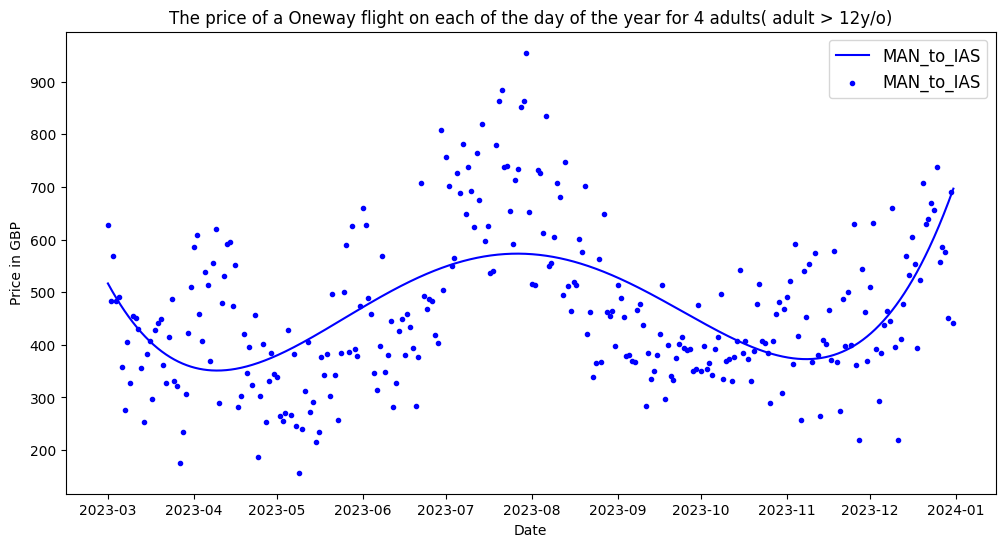

In [6]:
def plot(small_df,filename,  ax, colour):
    x = small_df[filename].index
    y = small_df[filename]['price']
    x_line= x.astype(int) / 10**9
    y = y.astype(int)
    x_line_dense = np.linspace(x_line.min(), x_line.max(), 4*len(x_line))
    x_dense = pd.to_datetime(x_line_dense, unit='s')

    p= np.polyfit(x_line, y, 4)
    y_line = np.polyval(p,x_line_dense)
    ax.plot(x_dense, y_line, label=filename, color=colour)

    ax.set_ylabel('Price in GBP')
    #ax.set_yticks(np.arange(0, np.max(y)+1, 100))
    ax.set_xlabel('Date')
    ax.set_title('The price of a Oneway flight on each of the day of the year for 4 adults( adult > 12y/o)')
    ax.scatter(x, y, marker ='.', color=colour, label=filename)
    ax.legend(fontsize=12)

fig, ax = plt.subplots(figsize =(12, 6))
#plot(BHX_to_IAS2,'BHX_to_IAS', ax, colour='red')
plot(small_df,'MAN_to_IAS', ax, colour='blue')
#plot(LTN_to_IAS2,'LTN_to_IAS', ax, colour='green')

